In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[1]  # adjust if needed
SRC_PATH = PROJECT_ROOT

sys.path.append(str(SRC_PATH))

In [2]:
from src.utils.baseline_models import get_model
from src.utils.transformations import get_transforms, get_collate_fn
from src.utils.dataloaders import get_train_dataloader, get_val_dataloader

import torch
import torchvision

import matplotlib.pyplot as plt

import json

c:\Users\jeist\Documents\Kuliah\MITB\CS604\plant-disease-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open(f"{PROJECT_ROOT}/configs/mixup/mixup_mobilenet_v3_small.json", "r") as f:
    config = json.load(f)

model = get_model(config["model_name"], pretrained=True)

transforms_config = config.get("transformations", None)

train_transform, val_transform, test_transform = get_transforms(
    model=model,
    model_name=config["model_name"],
    image_size=224,
    transforms_config=transforms_config
)

train_collate_fn = get_collate_fn(
    transforms_config=transforms_config
)

device = torch.device(
        "mps"
        if torch.backends.mps.is_available()
        else "cuda" if torch.cuda.is_available() else "cpu"
    )

# Data Paths
train_csv = Path(f"{PROJECT_ROOT}/data/splits") / "pv_train.csv"
val_csv = Path(f"{PROJECT_ROOT}/data/splits") / "pv_val.csv"

train_dataloader_without_cutmix = get_train_dataloader(
    train_csv,
    root_dir=PROJECT_ROOT,
    batch_size=32,
    transforms=train_transform,
    num_workers=0
)

train_dataloader_with_cutmix = get_train_dataloader(
    train_csv,
    root_dir=PROJECT_ROOT,
    batch_size=32,
    transforms=train_transform,
    collate_fn=train_collate_fn,
    num_workers=0
)

In [4]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(tensor):
    """
    tensor: (B, C, H, W) or (C, H, W)
    """
    if tensor.ndim == 4:
        mean_ = mean[None, :, None, None]
        std_ = std[None, :, None, None]
    else:  # (C, H, W)
        mean_ = mean[:, None, None]
        std_ = std[:, None, None]

    return tensor * std_ + mean_

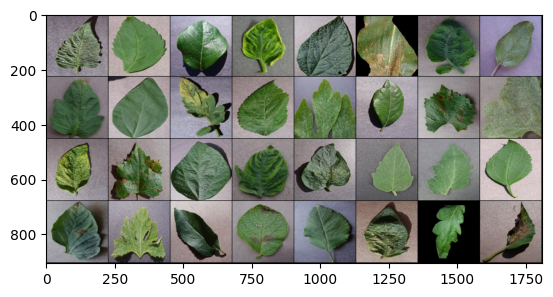

In [5]:
it = iter(train_dataloader_without_cutmix)

inputs, classes = next(it)
inputs = denormalize(inputs)
out = torchvision.utils.make_grid(inputs, nrow=8)
out = out.permute(1, 2, 0)
plt.imshow(out)

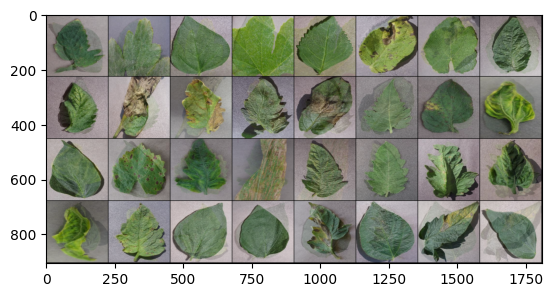

In [7]:
it = iter(train_dataloader_with_cutmix)

inputs, classes = next(it)
inputs = denormalize(inputs)
out = torchvision.utils.make_grid(inputs, nrow=8)
out = out.permute(1, 2, 0)
plt.imshow(out)

In [8]:
classes.shape

torch.Size([32, 26])